# **Exploring PCA on a Glass Identification Dataset**

---

## **Introduction**

In this notebook I will explore PCA (Principal Component Analysis) on a dataset. The dataset I will use is a glass identification dataset from the UCI Machine Learning Repository. The dataset contains 214 types of glass, each with 9 features. The dataset can be found [here](https://www.kaggle.com/datasets/uciml/glass/data).

> PCA is a dimensionality reduction technique used to reduce the number of features in a dataset while retaining as much of the variance as possible. It does this by finding the principal components of the data, which are the directions in which the data varies the most. These principal components are then used to transform the data into a new space with fewer dimensions.


## **Inhoudsopgave**

1. [Importing Libraries and Dataset](#1.-Importing-Libraries-and-Dataset)
2. [Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)
3. [Data Visualization](#3.-Data-Visualization)  
   3.1 [Distribution of Features](#3.1-Distribution-of-Features)  
   3.2 [Missing Values](#3.2-Missing-Values)  
   3.3 [Correlation Matrix](#3.3-Correlation-Matrix)
4. [Data Preprocessing](#4.-Data-Preprocessing)  
   4.1 [Z-Scores](#4.1-Z-Scores)  
   4.2 [Removing Outliers](#4.2-Removing-Outliers)  
   4.3 [Scaling the Data](#4.3-Scaling-the-Data)  
   4.4 [ANOVA](#4.4-ANOVA)
5. [Building the Models](#5.-Building-the-Models)  
   5.1 [PCA](#5.1-PCA)
6. [Conclusion](#6.-Conclusion)


## **1. Importing Libraries and Dataset**

---


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.stats import shapiro, f_oneway, stats
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [34]:
df = pd.read_csv('./data/glass.csv')
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


## **2. Exploratory Data Analysis**

[Table of Contents](#Table-of-Contents)

---


In [35]:
df.shape

(214, 10)

As mentioned, the dataset contains 214 samples and 10 columns. The columns are as follows:


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


The target variable is the 'Type' column, which is an integer. The other columns are all float64.


In [37]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


The features are not all on the same scale, `Si` has a mean of 72.65 while `K` has a mean of 0.497. This is important to note as PCA is sensitive to the scale of the features. Machine learning algorithms will also perform better if the features are on the same scale.


## **3. Data Visualization**

[Table of Contents](#Table-of-Contents)

---


#### **3.1 Distribution of Features**


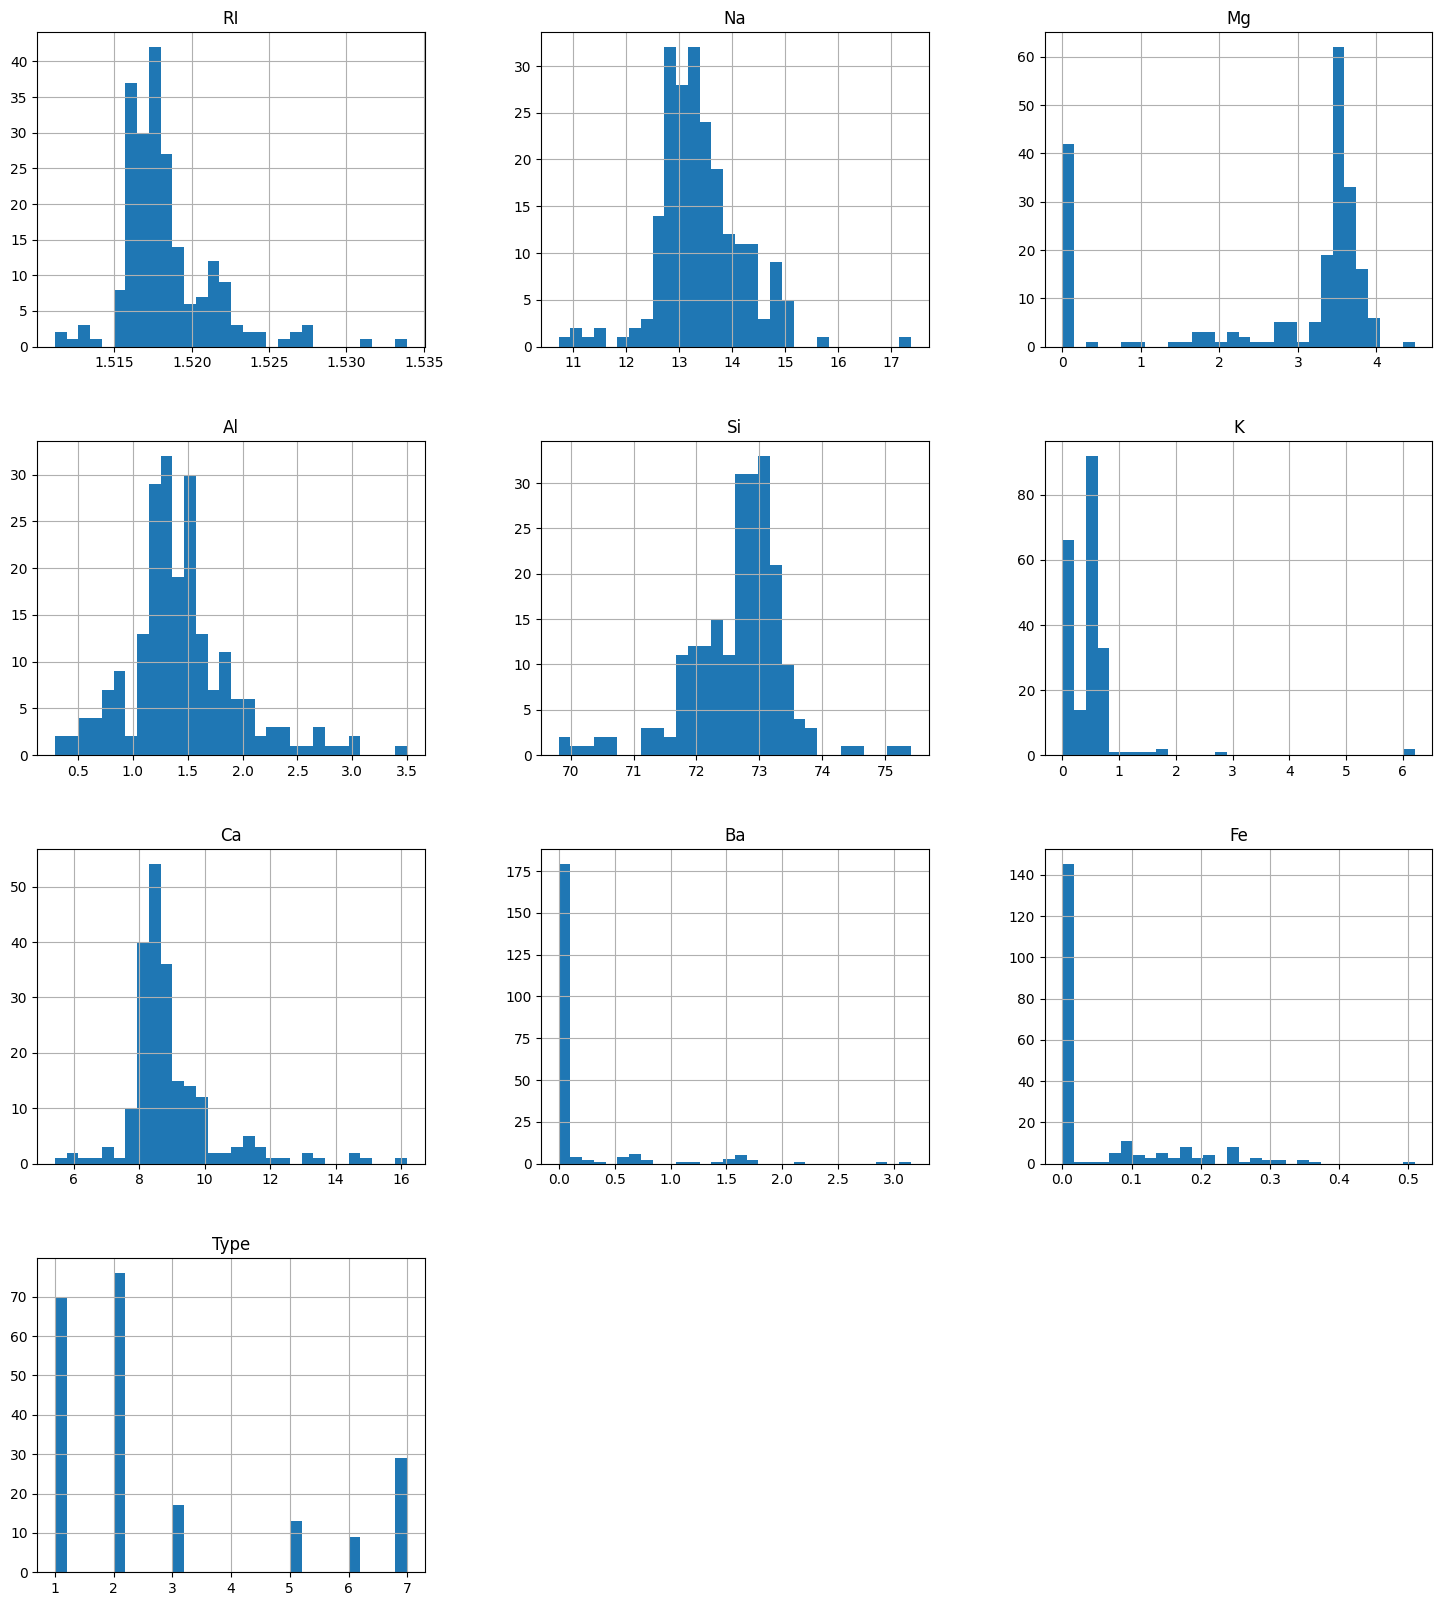

In [38]:
df.hist(bins=30, figsize=(18, 20))
plt.show()

None of the features seem normally distributed. Looking at the plots, `K`, `Ba`, and `Fe` are the most skewed. PCA assumes that the data is normally distributed, so it is important to keep this in mind.


In [39]:
features = df.columns[:-1]

for feature in features:
    stat, p = shapiro(df[feature])
    print(f'{feature}: stat={stat}, p={p}')
    if p > 0.05:
        print(f'{feature} is normally distributed')
    else:
        print(f'{feature} is not normally distributed')
    print()

RI: stat=0.8675722824224845, p=1.0766712928973257e-12
RI is not normally distributed

Na: stat=0.9457623069859671, p=3.4655426922932635e-07
Na is not normally distributed

Mg: stat=0.6993364173009177, p=2.390921270062536e-19
Mg is not normally distributed

Al: stat=0.9434125977963362, p=2.083156241596203e-07
Al is not normally distributed

Si: stat=0.919661913962691, p=2.175031659381684e-09
Si is not normally distributed

K: stat=0.44161768779031463, p=2.1721880356825683e-25
K is not normally distributed

Ca: stat=0.7938679083602006, p=4.2865840413758387e-16
Ca is not normally distributed

Ba: stat=0.4085650688572171, p=5.383301973907288e-26
Ba is not normally distributed

Fe: stat=0.6532001093351214, p=1.1566680199469388e-20
Fe is not normally distributed



Above I have used the Shaprio test to determine if the features are normally distributed. The p-values are all less than 0.05, which means that the features are not normally distributed.

> The Shapiro-Wilk test is a test of normality in a dataset. The null hypothesis is that the data is normally distributed. A p-value of less than 0.05 indicates that the data is not normally distributed.


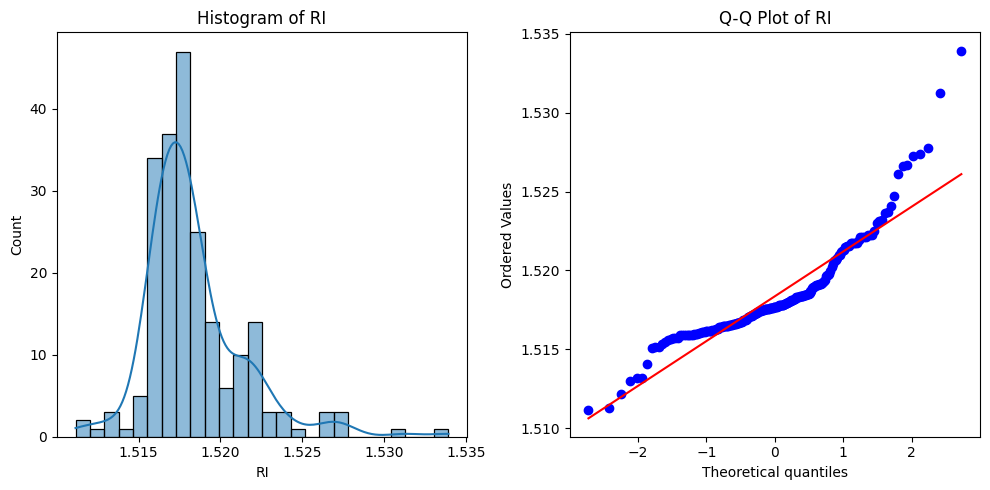

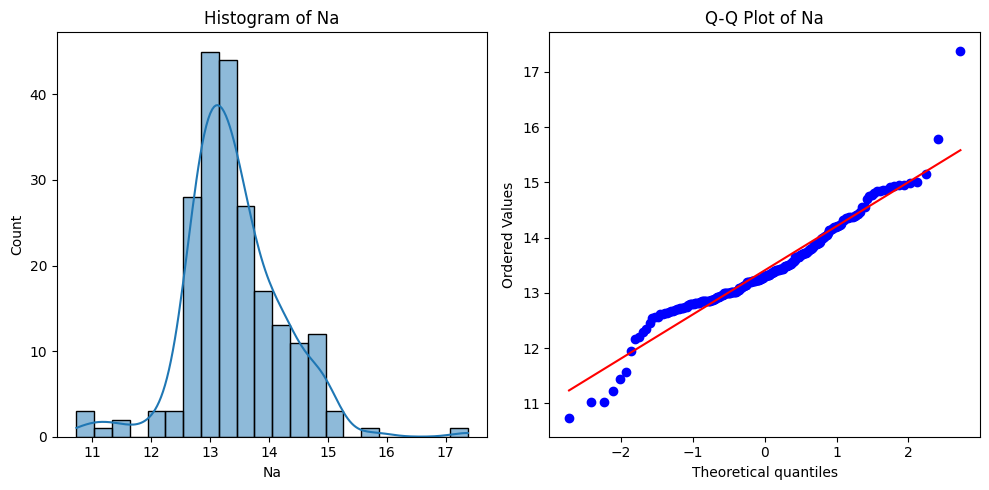

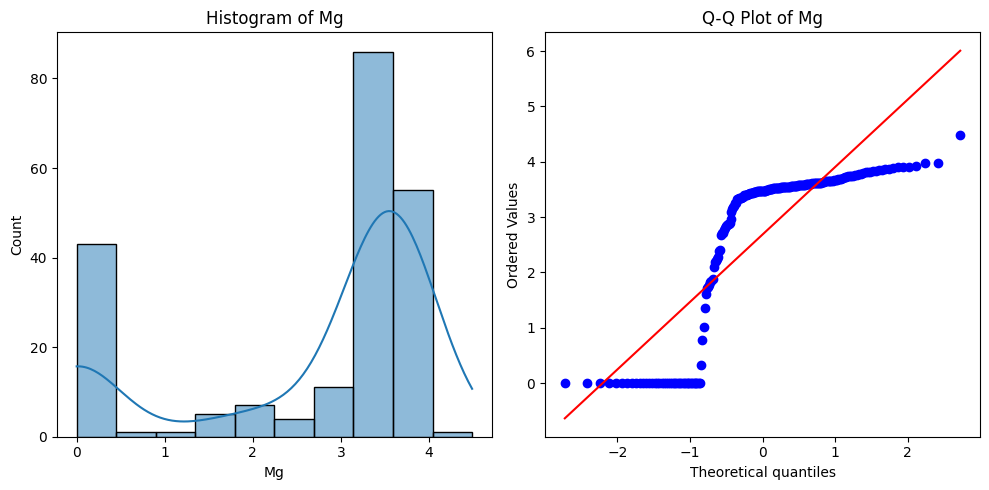

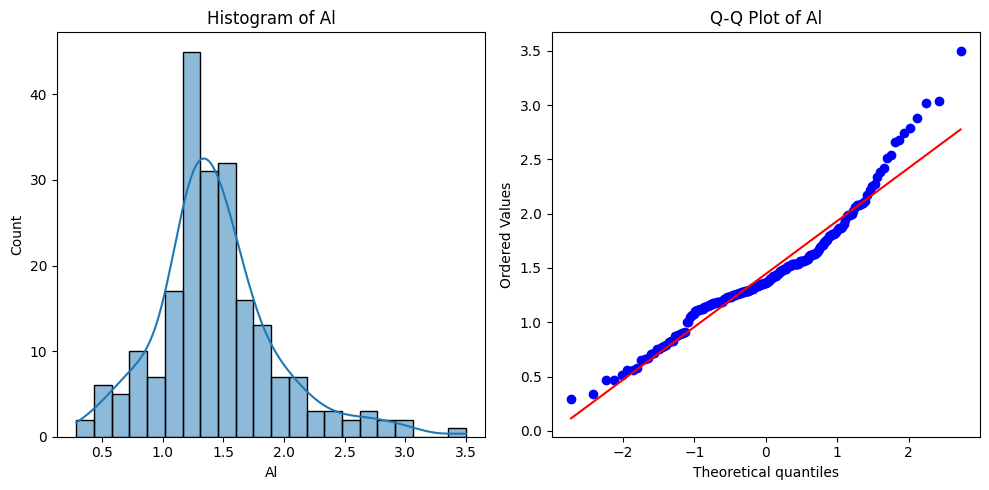

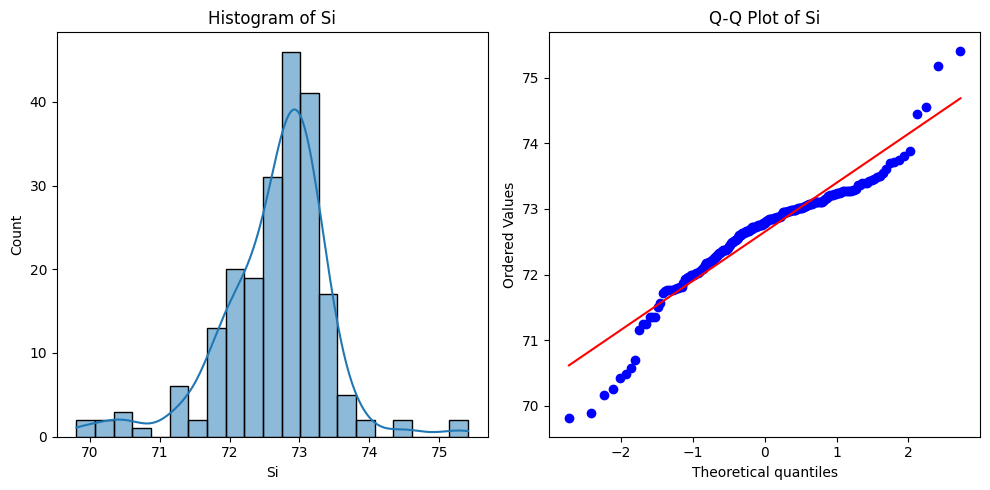

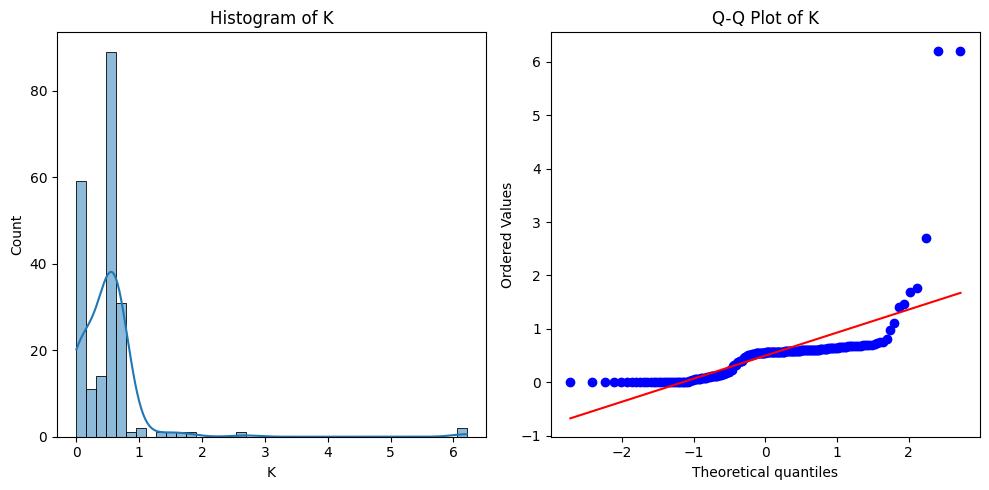

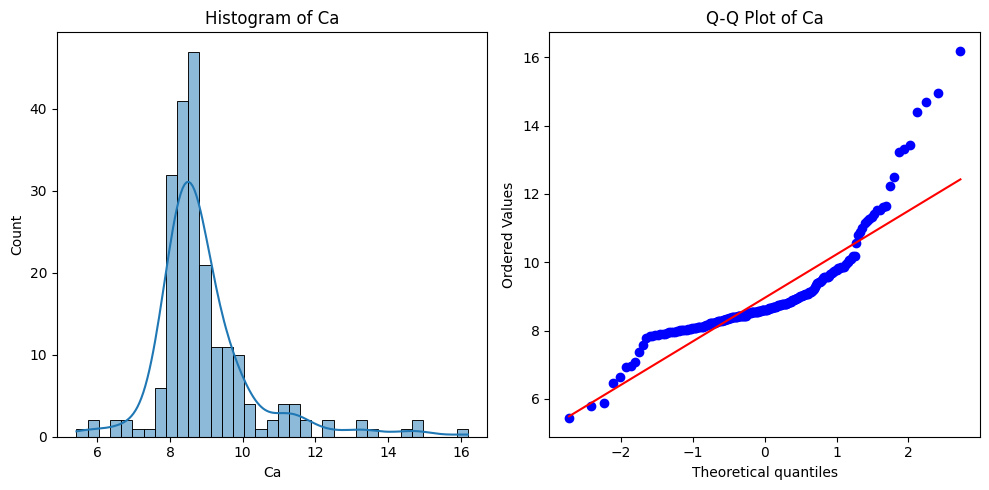

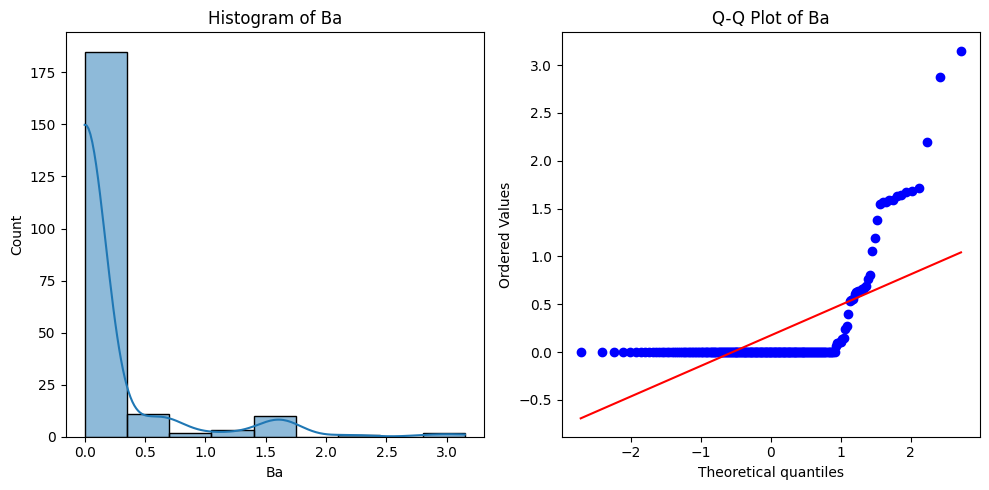

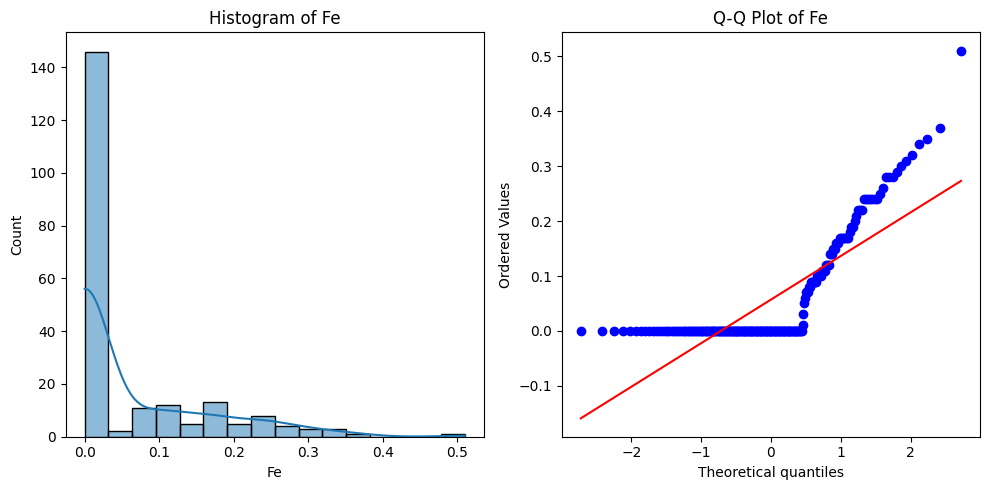

In [40]:
for feature in features:
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Histogram of {feature}')
    
    plt.subplot(1, 2, 2)
    stats.probplot(df[feature], dist="norm", plot=plt)
    plt.title(f'Q-Q Plot of {feature}')
    
    plt.tight_layout()
    plt.show()

Above I have created a Q-Q plot for each feature. This is a plot that compares the quantiles of the data to the quantiles of a normally distributed dataset. If the data is normally distributed, the points should lie on the line. From the plots, it is clear that the data is not normally distributed.

> A quantile is a value that divides the distribution of a dataset into a number of equal parts. For example, the 0.25 quantile is the value where 25% of the data is lower and 75% is higher.

A Q-Q plot compares the quantiles of the data to the quantiles of a normally distributed dataset. If the data is normally distributed, the points should lie on the line. Some plots show a clear deviation from the line, while others are almost on the line. This means that some features deviate more from a normal distribution than others.


#### **3.2 Missing Values**


In [41]:
df.isnull().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

There are no missing values in the dataset.


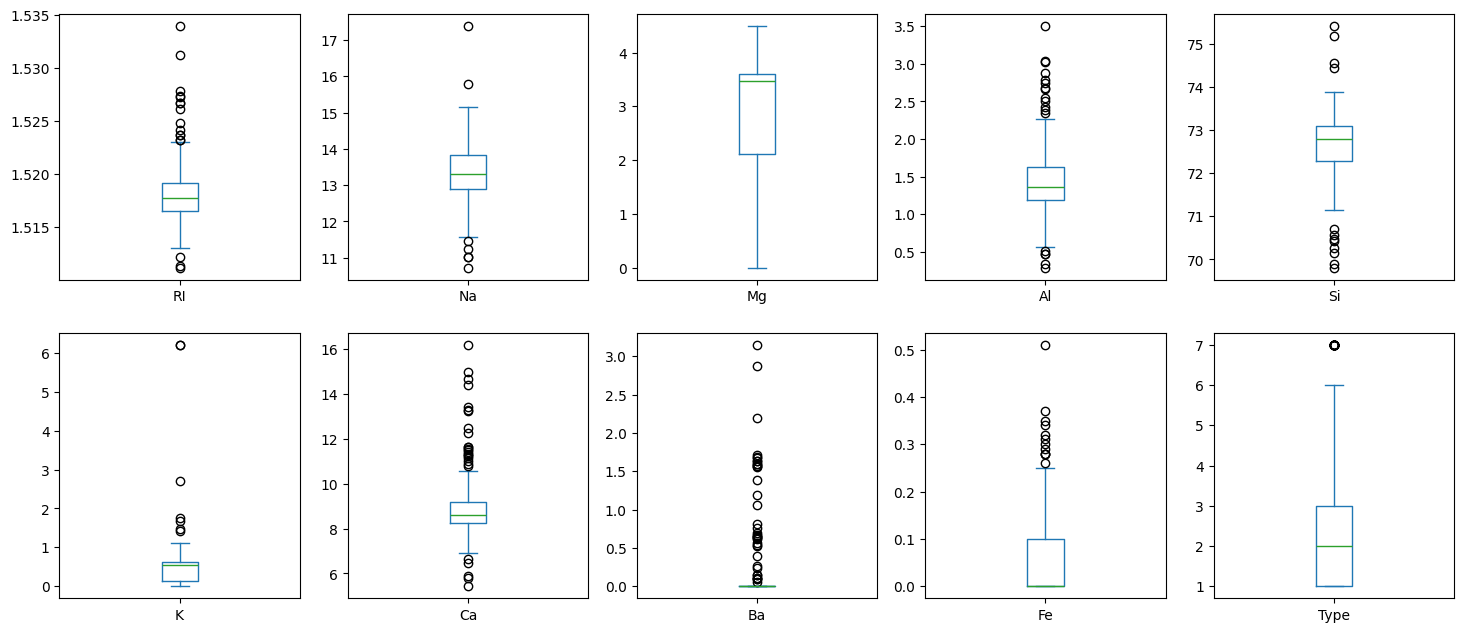

In [42]:
df.plot(kind='box', subplots=True, layout=(5,5), sharex=False, sharey=False, figsize=(18, 20))
plt.show()

There seem to be quite a few outliers in the dataset. I will make sure to remove these before applying PCA.


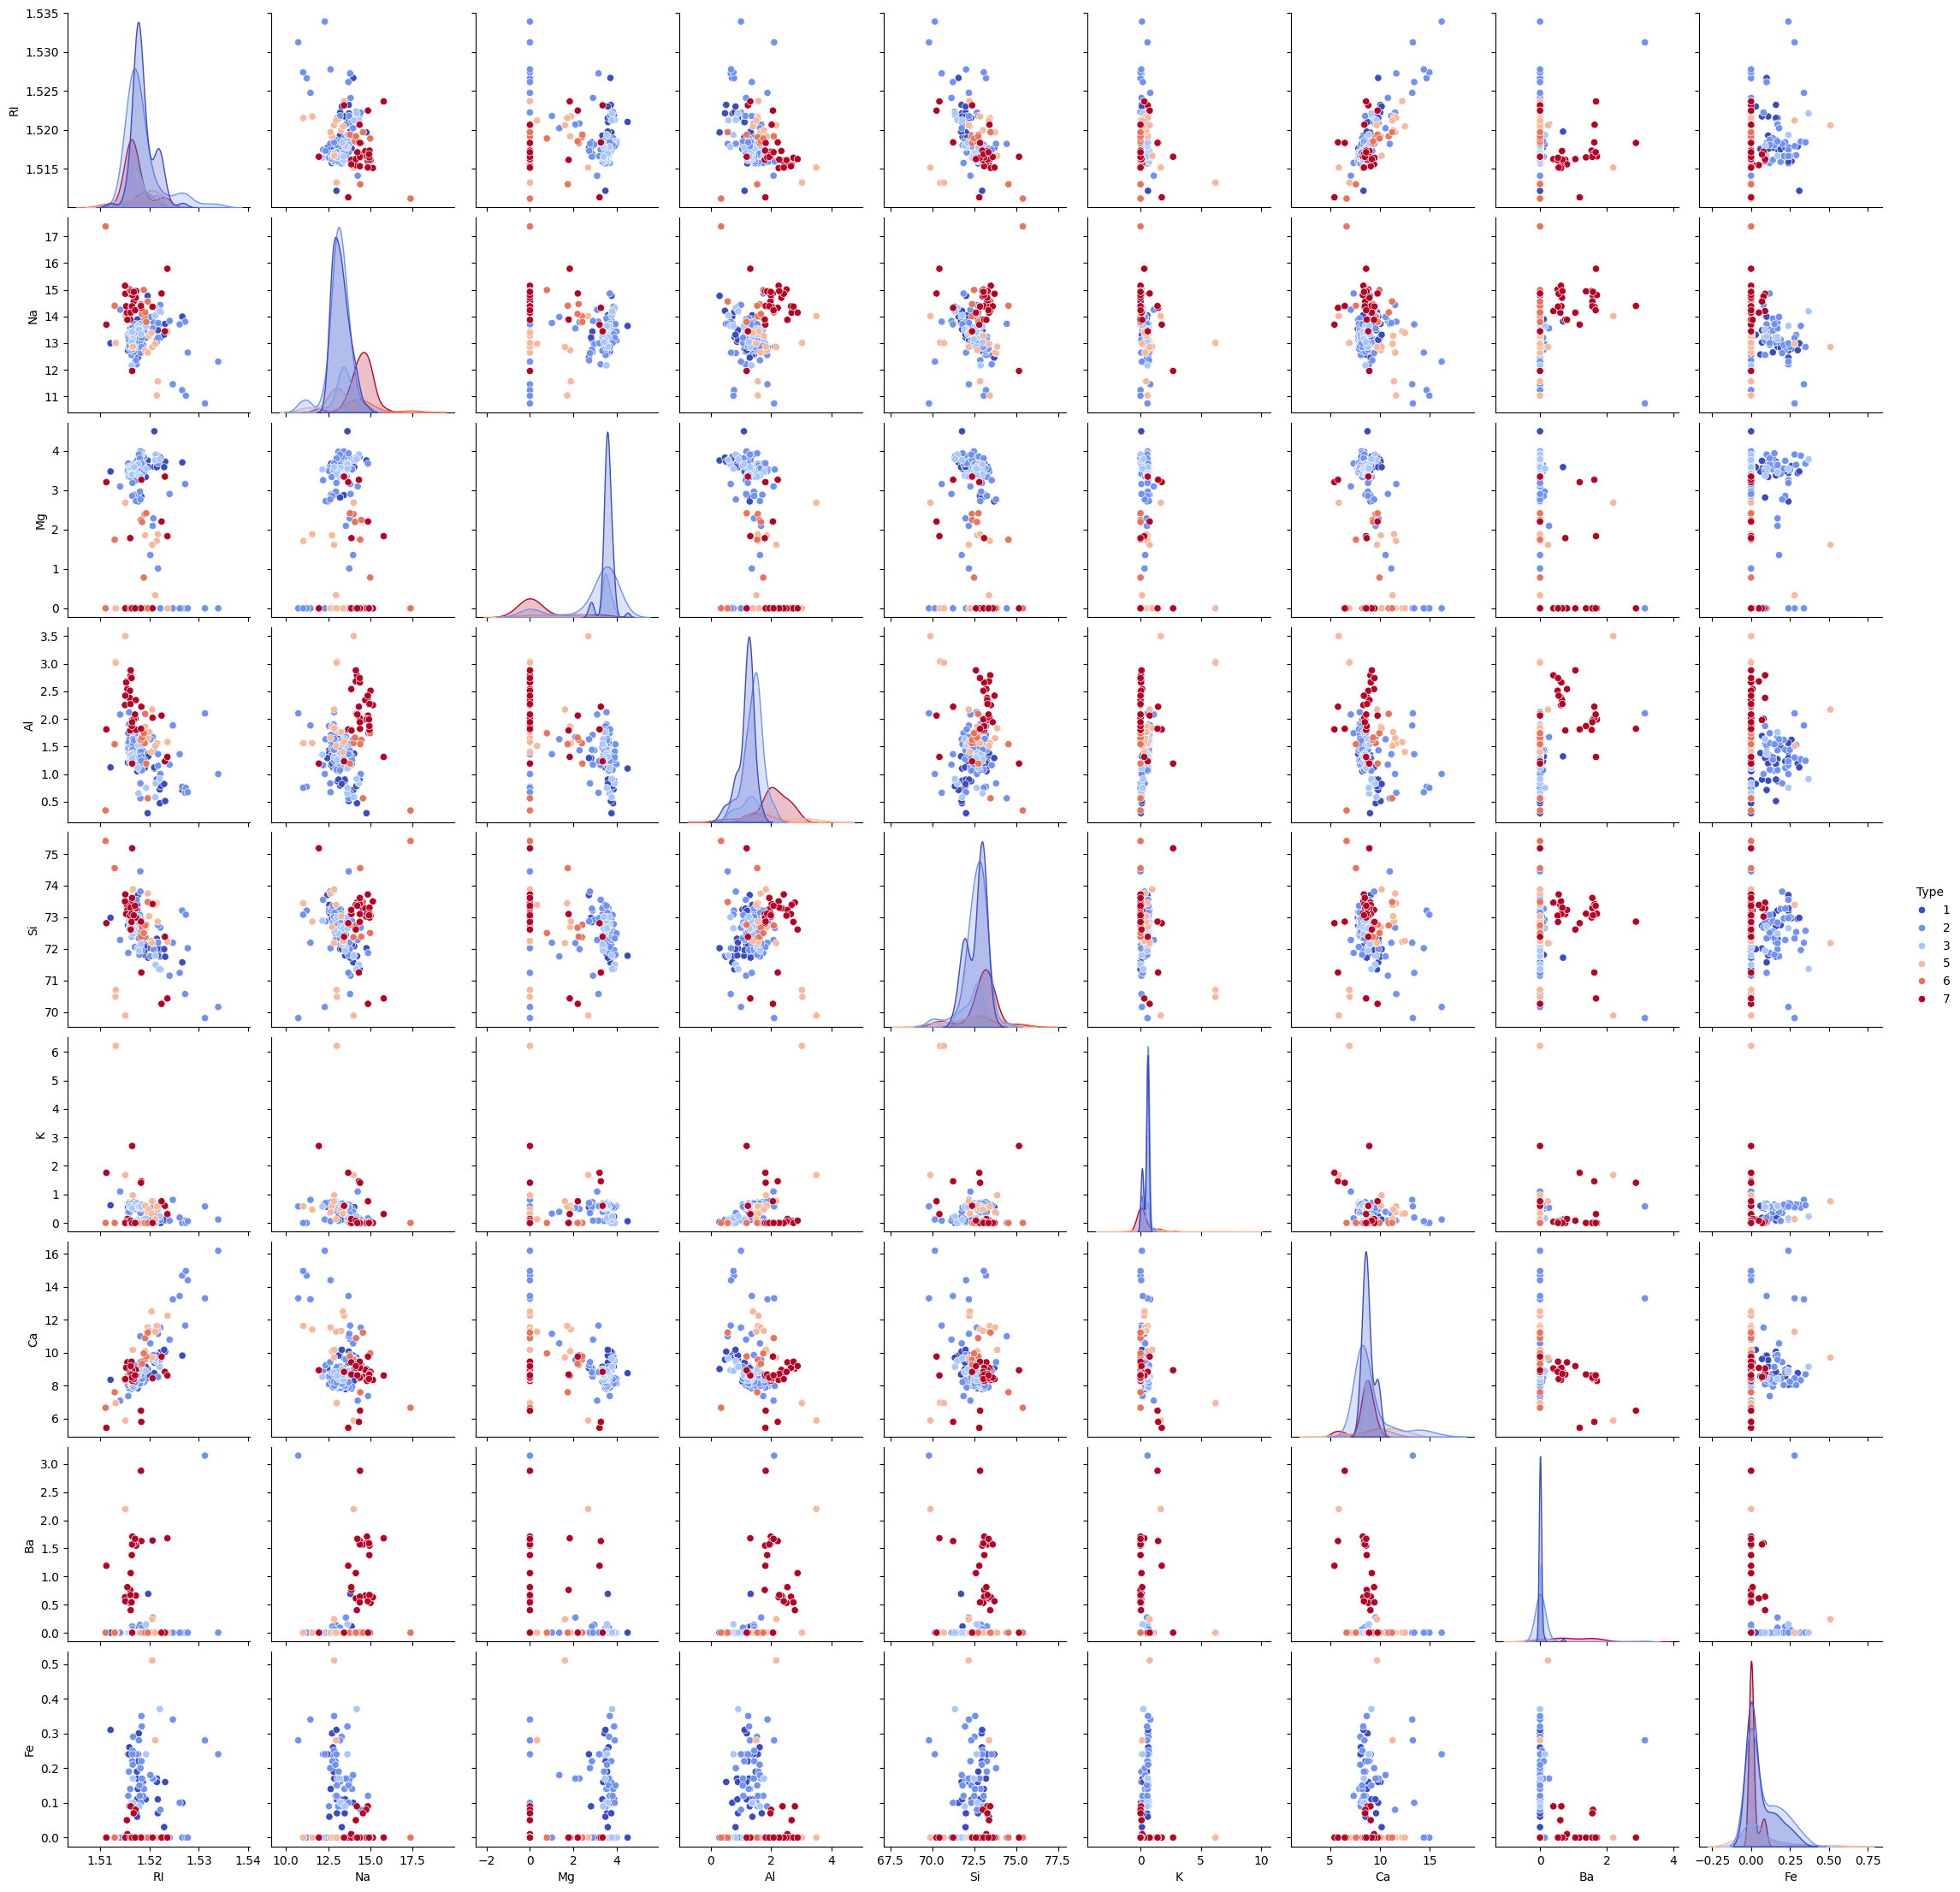

In [43]:
sns.pairplot(df, hue='Type', palette='coolwarm')
plt.show()

#### **3.3 Correlation Matrix**


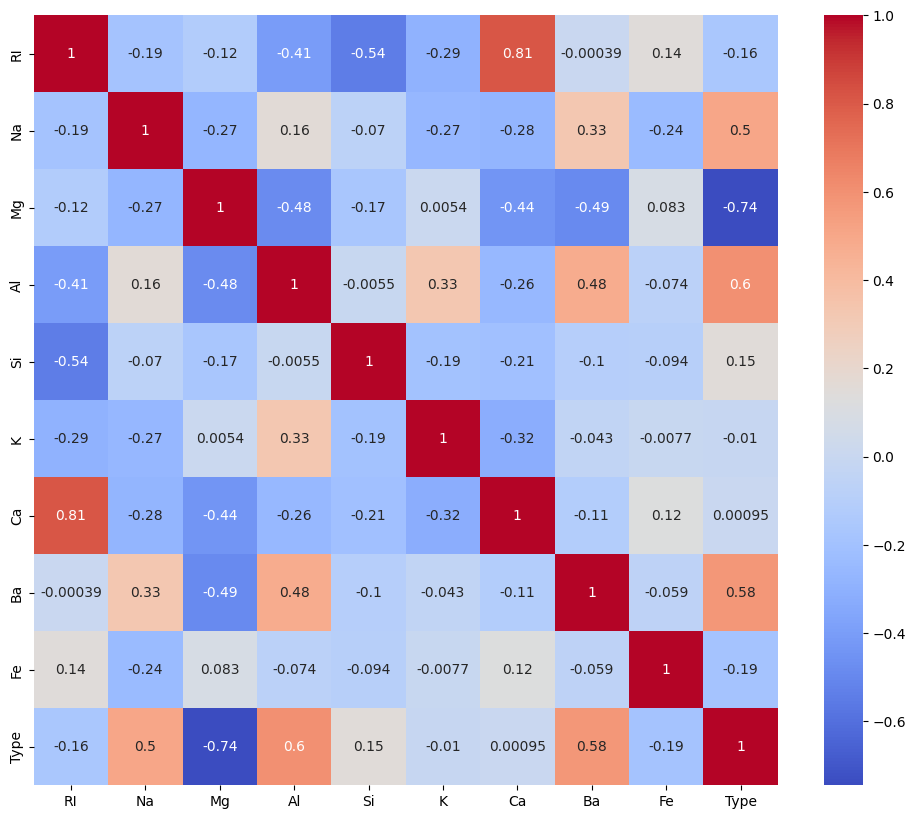

In [44]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm')
plt.show()

We can see a few correlations between the features. For example, `Ca` and `RI` have a correlation of 0.81. This is important to note as PCA assumes that the features are uncorrelated.

> In a correlations matrix we can see the correlation between the features. Positive values indicate a positive correlation, while negative values indicate a negative correlation. The closer the value is to 1 or -1, the stronger the correlation.


## **4. Data Preprocessing**

[Table of Contents](#Table-of-Contents)

---


#### **4.1 Z-Scores**


In [46]:
def calculate_z_scores(df):
    z_scores = (df - df.mean()) / df.std()
    return z_scores

df_z = calculate_z_scores(df.iloc[:, :-1])
df_z.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
0,0.870826,0.284287,1.251704,-0.690822,-1.124446,-0.670134,-0.145425,-0.352051,-0.585079
1,-0.248750,0.590433,0.634680,-0.170061,0.102080,-0.026152,-0.791877,-0.352051,-0.585079
2,-0.719631,0.149582,0.600016,0.190465,0.437760,-0.164148,-0.827010,-0.352051,-0.585079
3,-0.232286,-0.242285,0.697076,-0.310266,-0.052850,0.111844,-0.517838,-0.352051,-0.585079
4,-0.311315,-0.168810,0.648546,-0.410413,0.553957,0.081178,-0.623237,-0.352051,-0.585079


A z-score tells us how many standard deviations a data point is from the mean. Standard deviation measures the spread of data points around the mean. It tells us how far data points deviate from the mean on average.

#### **4.2 Removing Outliers**


In [47]:
def detect_outliers(df, n, features):
    outlier_indices = []
    for col in features:
        Q1 = np.percentile(df[col], 25)
        Q3 = np.percentile(df[col], 75)
        IQR = Q3 - Q1
        outlier_step = 1.5 * IQR
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step)].index
        outlier_indices.extend(outlier_list_col)
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v > n)
    return multiple_outliers

outliers_to_drop = detect_outliers(df, 2, df.columns[:-1])
print(f'Number of outliers: {len(outliers_to_drop)}')

df = df.drop(outliers_to_drop, axis=0).reset_index(drop=True)
df.shape

Number of outliers: 14


(200, 10)

Here I have removed the outliers from the dataset. I have removed any rows that contain more than 2 outliers. The reason I did not use regular z-scores is that the features are not normally distributed, and IQR removes too many rows. This is why I used Tukey's method.


#### **4.3 Scaling the Data**


In [48]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now that the dataset is split into features and target, I will scale the features using StandardScaler. This is important as PCA is sensitive to the scale of the features.


In [49]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

#### **4.4 ANOVA**

> ANOVA is a statistical test used to determine if there are significant differences between the means of three or more groups. In this case, I am using ANOVA to see if there is a significant difference between the mean values of each feature for each type of glass.

In [50]:
for column in df.columns[:-1]:  # Exclude the target variable (Type)
    groups = [df[df['Type'] == i][column] for i in [1, 2, 3, 5, 6, 7]]
    f_statistic, p_value = f_oneway(*groups)
    print(f"ANOVA for {column}: F-statistic = {f_statistic}, p-value = {p_value}")

ANOVA for RI: F-statistic = 4.831619627970085, p-value = 0.0003462943557943893
ANOVA for Na: F-statistic = 30.507937494473023, p-value = 7.933385394241488e-23
ANOVA for Mg: F-statistic = 107.62894256575782, p-value = 5.218816140863265e-54
ANOVA for Al: F-statistic = 42.162131216235956, p-value = 2.879072248447903e-29
ANOVA for Si: F-statistic = 4.502768151552335, p-value = 0.0006620346145020885
ANOVA for K: F-statistic = 10.822354835262944, p-value = 3.4072277958291268e-09
ANOVA for Ca: F-statistic = 16.17678068418469, p-value = 2.5296196453290686e-13
ANOVA for Ba: F-statistic = 81.07355741521808, p-value = 1.241018802045586e-45
ANOVA for Fe: F-statistic = 2.1228535417566325, p-value = 0.064334504367068


The null hypothesis of ANOVA is that the means of the groups are equal. A low p-value indicates that the means of the groups are not equal. From the results, we can see that the p-values for all features except Fe are less than 0.05, which means that the means of the groups differ. Fe gives a p-value of 0.06, which means that the means of the groups do not differ significantly. This means that Fe is likely not useful for classifying the glasses.

## **5. Building the Models**

[Table of Contents](#Table-of-Contents)

---

Before applying PCA, I will test a few models on the dataset to see how they perform. I will use a Decision Tree, Random Forest, and K-Nearest Neighbors.


In [51]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(f'{name} Training Score: {model.score(X_train, y_train)}')
    print(f'{name} Testing Score: {model.score(X_test, y_test)}')
    print()

results = []
names = []
for name, model in models.items():
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print(f'{name} Cross Validation Score: {cv_results.mean()}')


Logistic Regression Training Score: 0.74375
Logistic Regression Testing Score: 0.65

Decision Tree Training Score: 1.0
Decision Tree Testing Score: 0.725

Random Forest Training Score: 1.0
Random Forest Testing Score: 0.85

Logistic Regression Cross Validation Score: 0.6625
Decision Tree Cross Validation Score: 0.65
Random Forest Cross Validation Score: 0.75625


#### **5.1 PCA**


Now I will apply PCA to the dataset.


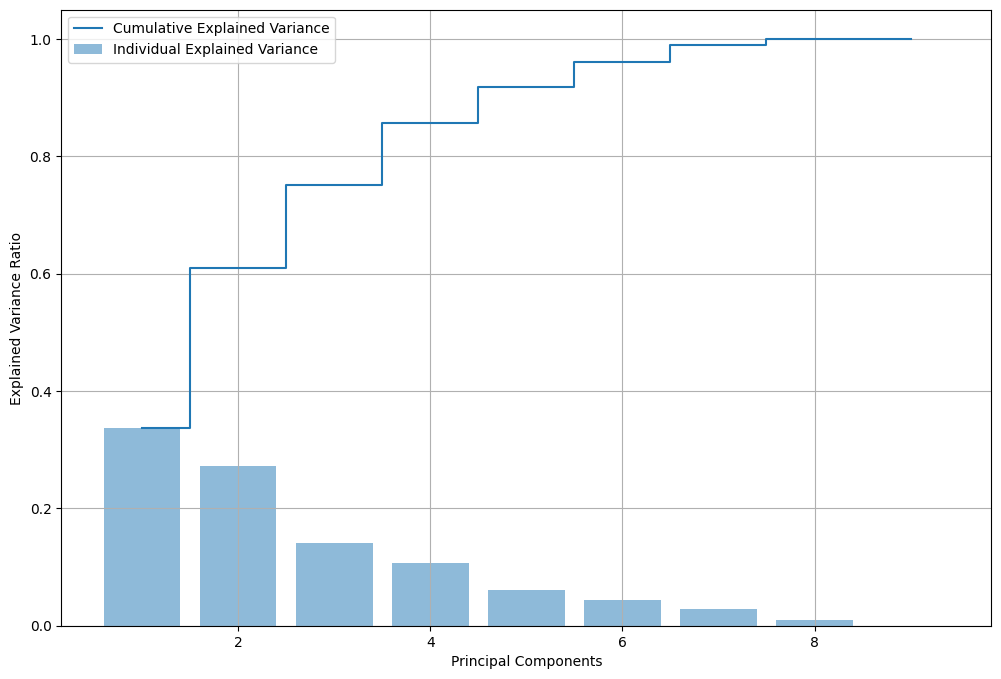

In [52]:
pca = PCA(random_state=42)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
cum_explained_variance = np.cumsum(explained_variance)

plt.figure(figsize=(12, 8))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual Explained Variance')
plt.step(range(1, len(cum_explained_variance) + 1), cum_explained_variance, where='mid', label='Cumulative Explained Variance')
plt.ylabel('Explained Variance Ratio')
plt.xlabel('Principal Components')
plt.legend(loc='best')
plt.grid()
plt.show()

Above is a plot of the explained variance ratio for each principal component. The plot shows that the first principal component explains most of the variance in the data. The second principal component explains the second most variance, and so on.


In [53]:
for i, sum_explained_variance in enumerate(cum_explained_variance):
    if sum_explained_variance > 0.95:
        n_components = i + 1
        break
    
print(f'Number of components to explain 95% variance: {n_components}')

Number of components to explain 95% variance: 6


We can see that the first 6 principal components explain 95% of the variance in the data. This is important to note as we can reduce the dimensionality of the dataset by only using the first 6 principal components.


In [54]:
pca = PCA(n_components=n_components, random_state=42)
X_train_pca = pca.fit_transform(X_train)

for name, model in models.items():
    model.fit(X_train_pca, y_train)
    print(f'{name} Training Score: {model.score(X_train_pca, y_train)}')
    print(f'{name} Testing Score: {model.score(pca.transform(X_test), y_test)}')
    print()
    
results = []
names = []
for name, model in models.items():
    kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, X_train_pca, y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    print(f'{name} Cross Validation Score: {cv_results.mean()}')

Logistic Regression Training Score: 0.7375
Logistic Regression Testing Score: 0.625

Decision Tree Training Score: 1.0
Decision Tree Testing Score: 0.55

Random Forest Training Score: 1.0
Random Forest Testing Score: 0.625

Logistic Regression Cross Validation Score: 0.68125
Decision Tree Cross Validation Score: 0.6125
Random Forest Cross Validation Score: 0.70625


Sadly, PCA did not improve the performance. I'm guessing this is because both the features are not normally distributed, as well as the fact that PCA is unable to capture the non-linear relationships between the features.


## **6. Conclusion**

[Table of Contents](#Table-of-Contents)

---

In this notebook, I explored the application of PCA on a glass identification dataset. I found that the features are not normally distributed, and that there are quite a few outliers in the dataset. I tried to remove the outliers using Tukey's method, and scaled the features using StandardScaler.

Before applying PCA, I conducted a model evaluation using three different classifiers: Logistic Regression, Decision Tree, and Random Forest. Afterwards, I applied PCA to reduce the dimensionality of the dataset and re-evaluated the models using the transformed data.

The results indicate that PCA did not improve the performance of the models in this specific scenario. Despite reducing the dimensionality of the dataset and capturing a significant portion of the variance (95%) with just six principal components, the models' accuracy did not show improvement.

From what I can gather, there are several possible reason for this:

1. The features are not normally distributed, which is an assumption of PCA.
2. PCA is unable to capture the non-linear relationships between the features.
3. Although I scaled the features, it may not have been sufficient to reduce the imapct of non-normal distribution and non-linear relationships.
4. The models I used may not have been suitable for the dataset.

In conclusion, while PCA is a good technique for dimensionality reduction and can often improve model performance by simplifying the dataset, it may not always yield better results. Especially in this case, where the data does not adhere to its assumptions or where non-linear relationships play a significant role.
